In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import tempfile
import time
from datetime import datetime, timedelta
from os import path

import contextily as cx
import pandas as pd
import tqdm
from meteostations.clients import agrometeo

import tstore

/home/martibosch/mambaforge/envs/tstore/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Your first TStore

In this tutorial, we will build a TStore of observations from the meteorological stations operated by [Agrometeo](https://www.agrometeo.ch/) [<sup>1</sup>](#agrometeo) in the Canton of Vaud, Switzerland during the last 5 years. We will use the [meteostations-geopy](https://github.com/martibosch/metastations-geopy) package to fetch the data. For this tutorial, you need to install the `feat-multivar-df` branch, e.g.:

```
pip install git+ssh://git@github.com/martibosch/meteostations-geopy.git@feat-multivar-df
```

Let us first have a look at the stations' locations:

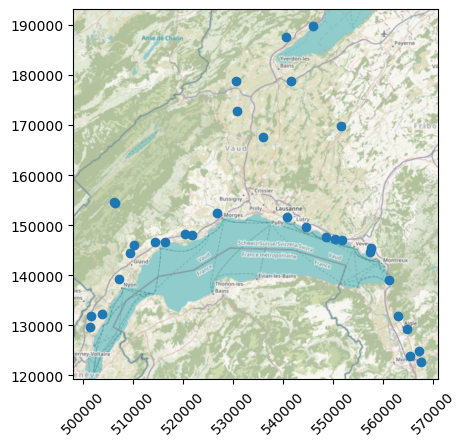

In [ ]:
region = "Canton de Vaud"

client = agrometeo.AgrometeoClient(region)

ax = client.stations_gdf.plot()
cx.add_basemap(ax=ax, crs=client.stations_gdf.crs, attribution="")
ax.tick_params(axis="x", labelrotation=45)
# ax.get_figure().savefig("")

Likewise many other APIs, Agrometeo limits the amount of data that can be fetched in a single request. Therefore, we will fetch the data in chunks of 1 month and concatenate it. Let's start by looking at 1-month chunk of data:

In [ ]:
variables = ["temperature", "water_vapour", "precipitation"]
start_date = "2021-01-01"
end_date = "2021-01-31"
client.get_ts_df(variables, start_date, end_date)

station                     1                                      3    \
variable            temperature water_vapour precipitation temperature   
time                                                                     
2021-01-01 00:00:00         2.2         99.0           0.2         2.5   
2021-01-01 00:10:00         2.3         99.0           0.2         2.6   
2021-01-01 00:20:00         2.4         99.0           0.1         2.8   
2021-01-01 00:30:00         2.4         99.0           0.2         2.8   
2021-01-01 00:40:00         2.5         99.0           0.2         2.8   
...                         ...          ...           ...         ...   
2021-01-31 23:10:00         5.7         99.0           0.0         6.6   
2021-01-31 23:20:00         5.9         99.0           0.4         6.6   
2021-01-31 23:30:00         6.1         99.0           0.2         6.5   
2021-01-31 23:40:00         6.1         98.0           0.3         6.5   
2021-01-31 23:50:00         6.1         99.0           0.3         6.5   

station                                                4                 \
variable            water_vapour precipitation temperature water_vapour   
time                                                                      
2021-01-01 00:00:00         96.0           0.0         2.3         94.0   
2021-01-01 00:10:00         96.0           0.2         2.4         94.0   
2021-01-01 00:20:00         95.0           0.1         2.4         94.0   
2021-01-01 00:30:00         94.0           0.2         2.4         94.0   
2021-01-01 00:40:00         94.0           0.1         2.5         94.0   
...                          ...           ...         ...          ...   
2021-01-31 23:10:00         93.0           0.5         5.7         96.0   
2021-01-31 23:20:00         94.0           0.4         6.0         95.0   
2021-01-31 23:30:00         94.0           0.4         6.1         95.0   
2021-01-31 23:40:00         95.0           0.3         6.2         94.0   
2021-01-31 23:50:00         96.0           0.9         6.2         94.0   

station                                   10   ...           98          99   \
variable            precipitation temperature  ... precipitation temperature   
time                                           ...                             
2021-01-01 00:00:00           0.2         3.2  ...           0.5         0.1   
2021-01-01 00:10:00           0.2         3.1  ...           0.4         0.0   
2021-01-01 00:20:00           0.2         3.3  ...           0.2        -0.0   
2021-01-01 00:30:00           0.2         3.1  ...           0.3         0.0   
2021-01-01 00:40:00           0.2         3.0  ...           0.3         0.1   
...                           ...         ...  ...           ...         ...   
2021-01-31 23:10:00           0.0         5.7  ...           0.1         5.6   
2021-01-31 23:20:00           0.6         5.8  ...           0.4         5.6   
2021-01-31 23:30:00           0.2         6.0  ...           0.0         5.7   
2021-01-31 23:40:00           0.4         5.8  ...           0.2         5.4   
2021-01-31 23:50:00           0.2         6.0  ...           0.2         5.3   

station                                                301               \
variable            water_vapour precipitation temperature water_vapour   
time                                                                      
2021-01-01 00:00:00        100.0           0.0         0.3        100.0   
2021-01-01 00:10:00        100.0           0.0         0.3        100.0   
2021-01-01 00:20:00        100.0           0.0         0.2        100.0   
2021-01-01 00:30:00        100.0           0.0         0.2        100.0   
2021-01-01 00:40:00        100.0           0.0         0.2        100.0   
...                          ...           ...         ...          ...   
2021-01-31 23:10:00        100.0           0.1         6.6         88.0   
2021-01-31 23:20:00        100.0         

Let us now iteratively assemble 5 years of data:

In [ ]:
num_years = 5
# https://pandas.pydata.org/docs/user_guide/timeseries.html#period-aliases
freq = "1MS"

yesterday = datetime.now().replace(
    hour=0,
    minute=0,
    second=0,
    microsecond=0,
) - timedelta(days=1)
date_range = pd.date_range(
    yesterday - timedelta(days=365 * num_years),
    yesterday,
    freq=freq,
)

ts_df = pd.concat(
    [
        client.get_ts_df(variables, start_date, end_date - timedelta(days=1))
        for start_date, end_date in tqdm.tqdm(
            zip(date_range[:-1], date_range[1:]),
            total=len(date_range) - 1,
        )
    ],
)
ts_df

100%|████████████████████████████████████████████████| 59/59 [01:03<00:00,  1.07s/it]


station                     1                                      3    \
variable            temperature water_vapour precipitation temperature   
time                                                                     
2019-07-01 00:00:00        23.8         54.0           0.0        20.9   
2019-07-01 00:10:00        23.2         59.0           0.0        21.0   
2019-07-01 00:20:00        23.4         56.0           0.0        20.8   
2019-07-01 00:30:00        22.0         68.0           0.0        20.3   
2019-07-01 00:40:00        20.9         73.0           0.0        20.7   
...                         ...          ...           ...         ...   
2024-05-31 23:10:00        11.2         99.0           0.0        11.6   
2024-05-31 23:20:00        11.2         99.0           0.0        11.5   
2024-05-31 23:30:00        11.2         99.0           0.0        11.2   
2024-05-31 23:40:00        11.3         99.0           0.0        10.9   
2024-05-31 23:50:00        11.3         99.0           0.0        10.8   

station                                                4                 \
variable            water_vapour precipitation temperature water_vapour   
time                                                                      
2019-07-01 00:00:00         77.0           0.0        24.9         48.0   
2019-07-01 00:10:00         74.0           0.0        23.4         59.0   
2019-07-01 00:20:00         76.0           0.0        22.3         63.0   
2019-07-01 00:30:00         79.0           0.0        22.0         64.0   
2019-07-01 00:40:00         74.0           0.0        21.8         66.0   
...                          ...           ...         ...          ...   
2024-05-31 23:10:00         96.0           0.0        10.7         99.0   
2024-05-31 23:20:00         96.0           0.0        10.8         99.0   
2024-05-31 23:30:00         96.0           0.0        10.9         99.0   
2024-05-31 23:40:00         94.0           0.0        11.1         99.0   
2024-05-31 23:50:00         95.0           0.0        11.1         99.0   

station                                   10   ...           98          99   \
variable            precipitation temperature  ... precipitation temperature   
time                                           ...                             
2019-07-01 00:00:00           0.0        23.0  ...           0.0        21.1   
2019-07-01 00:10:00           0.0        22.4  ...           0.0        21.6   
2019-07-01 00:20:00           0.0        22.5  ...           0.0        22.4   
2019-07-01 00:30:00           0.0        20.9  ...           0.0        23.4   
2019-07-01 00:40:00           0.0        22.3  ...           0.2        22.9   
...                           ...         ...  ...           ...         ...   
2024-05-31 23:10:00           0.0        11.8  ...           0.0        10.7   
2024-05-31 23:20:00           0.0        11.8  ...           0.0        10.7   
2024-05-31 23:30:00           0.0        11.8  ...           0.0        10.7   
2024-05-31 23:40:00           0.0        11.8  ...           0.0        10.6   
2024-05-31 23:50:00           0.0        11.6  ...           0.0        10.5   

station                                                301               \
variable            water_vapour precipitation temperature water_vapour   
time                                                                      
2019-07-01 00:00:00         93.0           0.0        22.8         78.0   
2019-07-01 00:10:00         83.0           0.0        24.0         65.0   
2019-07-01 00:20:00         65.0           0.0        24.6         53.0   
2019-07-01 00:30:00         55.0           0.0        23.9         56.0   
2019-07-01 00:40:00         62.0           0.0        24.2         55.0   
...                          ...           ...         ...          ...   
2024-05-31 23:10:00        100.0           0.0        11.7         95.0   
2024-05-31 23:20:00        100.0         

###### TODO: implement `to_tstore` method for wide dataframes.

The data frame above corresponds to the "wide" format of the data. In order to build a TStore, we need to transform it into the "long" format. We can do this by stacking the columns of the data frame:

In [ ]:
long_ts_df = ts_df.stack(level=0, future_stack=True).swaplevel().sort_index()
long_ts_df

variable                     temperature  water_vapour  precipitation
station time                                                         
1       2019-07-01 00:00:00         23.8          54.0            0.0
        2019-07-01 00:10:00         23.2          59.0            0.0
        2019-07-01 00:20:00         23.4          56.0            0.0
        2019-07-01 00:30:00         22.0          68.0            0.0
        2019-07-01 00:40:00         20.9          73.0            0.0
...                                  ...           ...            ...
305     2024-05-31 23:10:00         12.8          99.0            0.0
        2024-05-31 23:20:00         12.8          98.0            0.0
        2024-05-31 23:30:00         12.9          96.0            0.0
        2024-05-31 23:40:00         13.0          96.0            0.0
        2024-05-31 23:50:00         12.9          98.0            0.0

[8539113 rows x 3 columns]

## Writing to a TStore

We can now dump this data frame into a tstore:

In [ ]:
def get_tstore_filepaths(base_dir):
    return [
        path.join(dp, f) for dp, dn, filenames in os.walk(base_dir) for f in filenames
    ]


tstore_dir = "agrometeo-tstore"
tslong = tstore.TSLong(long_ts_df.reset_index())
start = time.time()
tslong.to_tstore(
    # TSTORE options
    tstore_dir,
    # DFLONG attributes
    "station",
    "time",
    variables,
    # TSTORE options
    partitioning="year",
    tstore_structure="id-var",
    overwrite=True,
)
print(f"Dumped tstore in: {time.time() - start:.2f} s")
tstore_filepaths = get_tstore_filepaths(tstore_dir)
for line in tstore_filepaths[:5] + ["..."] + tstore_filepaths[-5:]:
    print(line)

total_size = sum(path.getsize(tstore_filepath) for tstore_filepath in tstore_filepaths)
print(f"Total size: {total_size/1e6} MB (in {len(tstore_filepaths)} files)")

Dumped tstore in: 3.99 s
agrometeo-tstore/tstore_metadata.yaml
agrometeo-tstore/_attributes.parquet
agrometeo-tstore/96/temperature/_common_metadata
agrometeo-tstore/96/temperature/_metadata
agrometeo-tstore/96/temperature/year=2020/part-0.parquet
...
agrometeo-tstore/27/precipitation/year=2021/part-0.parquet
agrometeo-tstore/27/precipitation/year=2019/part-0.parquet
agrometeo-tstore/27/precipitation/year=2022/part-0.parquet
agrometeo-tstore/27/precipitation/year=2023/part-0.parquet
agrometeo-tstore/27/precipitation/year=2024/part-0.parquet
Total size: 250.006137 MB (in 794 files)


We can see that this creates a hierarchical structure in which for each station id, a folder is created for variable. Each variable folder is composed of metadata as well as the actual data partitioned by months (as specified with the `partitioning` argument). Note that the file sizes are quite small which is likely inefficient [<sup>2</sup>](#parquet-file-size).

## Reading from a TStore

We can read a TStore into a pandas data frame using `tstore.open_tslong`:

In [ ]:
start = time.time()
ts_df = tstore.open_tslong(tstore_dir)
print(f"Read tstore in: {time.time() - start:.2f} s")

Read tstore in: 19.58 s


Reading the whole TStore can be long, however, we may only be interested in specific subsets, e.g., we can read data for a specific time period only:

In [ ]:
start = time.time()
ts_2021_df = tstore.open_tslong(
    tstore_dir,
    start_time="2021-01-01",
    end_time="2021-01-31",
)
print(f"Read tstore for one year in: {time.time() - start:.2f} s")

Read tstore for one year in: 2.08 s


in which case reading times are dramatically reduced. Similarly, we may be interested in reading a single variable:

In [ ]:
start = time.time()
variable = "temperature"
T_ts_df = tstore.open_tslong(tstore_dir, ts_variables=variable)
print(f"Read tstore for one variable in: {time.time() - start:.2f} s")

Read tstore for one variable in: 2.28 s


We can actually use the two filters simoultaneously:

In [ ]:
start = time.time()
variable = "temperature"
T_ts_2021_df = tstore.open_tslong(
    tstore_dir,
    ts_variables=variable,
    start_time="2021-01-01",
    end_time="2021-01-31",
)
print(f"Read tstore for one variable, one year in: {time.time() - start:.2f} s")

Read tstore for one variable, one year in: 0.11 s


Note that in all the above examples the data has been loaded into a pandas data frame. However, we may also read it into a different backend, e.g., polars:

In [ ]:
start = time.time()
variable = "temperature"
ts_pl_df = tstore.open_tslong(tstore_dir, backend="polars", ts_variables=variable)
print(
    f"Read tstore for one variable into polars data frame in: {time.time() - start:.2f} s",
)
ts_pl_df

Read tstore for one variable into polars data frame in: 4.26 s


station,temperature,time
str,f64,datetime[ns]
"""96""",4.1,2024-01-01 00:00:00
"""96""",4.0,2024-01-01 00:10:00
"""96""",4.4,2024-01-01 00:20:00
"""96""",4.4,2024-01-01 00:30:00
"""96""",4.5,2024-01-01 00:40:00
…,…,…
"""27""",3.8,2023-12-31 23:10:00
"""27""",3.7,2023-12-31 23:20:00
"""27""",3.6,2023-12-31 23:30:00


## Reading from a TStore into a TSDF

When reading into long or wide data frames as shown above, the (potentially filtered) data is loaded into memory and returned into the desired object (e.g., pandas or polars data frames).

However, we can also read the structure of the TStore without actually loading the data into memory. This is done with the `tstore.open_tsdf`, which returns a `TSDF` object - a pandas data frame of `TS` objects:

In [ ]:
tsdf = tstore.open_tsdf(tstore_dir)
tsdf

,temperature,water_vapour,precipitation
station,,,
1,TS[shape=(Delayed('int-b7217cba-b120-45d7-bee1...,TS[shape=(Delayed('int-6187edff-13da-4ea4-844a...,TS[shape=(Delayed('int-049d81f9-f393-4c72-b73c...
3,TS[shape=(Delayed('int-163b43b7-50a6-403d-a272...,TS[shape=(Delayed('int-6acff6ee-992e-4702-b7dc...,TS[shape=(Delayed('int-79ff12fd-1bbf-4031-b822...
4,TS[shape=(Delayed('int-2bae2cf8-e35e-42ae-9348...,TS[shape=(Delayed('int-73e5f899-f973-47a4-a651...,TS[shape=(Delayed('int-da4ba8c7-1ef7-47d9-9d3c...
10,TS[shape=(Delayed('int-6f63c909-3966-4a37-b2b1...,TS[shape=(Delayed('int-45f9fe4b-103b-4ad4-a20a...,TS[shape=(Delayed('int-98cd7cf4-db8f-4643-a744...
13,TS[shape=(Delayed('int-2da36ae1-bc65-4d9d-8ab5...,TS[shape=(Delayed('int-bfb0f92e-fa92-4f0f-813c...,TS[shape=(Delayed('int-36248a75-abb9-43d2-bda2...
16,TS[shape=(Delayed('int-f90111e3-05dc-4498-b9fb...,TS[shape=(Delayed('int-a96a18f3-0589-4f46-9277...,TS[shape=(Delayed('int-bb1830ea-89a8-43ff-9ee6...
22,TS[shape=(Delayed('int-4df98efd-f794-4d07-85ad...,TS[shape=(Delayed('int-83624b8c-ad21-4d89-93c2...,TS[shape=(Delayed('int-623aa1e6-0f33-4345-b8b6...
27,TS[shape=(Delayed('int-b80556fc-bced-453b-8007...,TS[shape=(Delayed('int-58f58bed-1898-4ab3-b7db...,TS[shape=(Delayed('int-b2658562-4fc7-422d-a957...
29,TS[shape=(Delayed('int-79a4c7bb-40e1-49cf-8ce6...,TS[shape=(Delayed('int-1d2ee3b6-8f33-4f39-8559...,TS[shape=(Delayed('int-0c602078-fb2d-4958-b63c...


We can now use pandas indexing methods to select the target data and then load it into memory using the `TS.data.compute()` method, so that only the required files are read:

In [ ]:
start = time.time()
station = "1"
tsdf.loc[station, variable].data.compute()
print(
    f"Read tstore for station {station} and {variable} in: {time.time() - start:.2f} s",
)

Read tstore for station 1 and temperature in: 1.78 s


###### TODO: tstore interface to lazily load data from a TSDF, e.g.:

```python
class TSDF(...):
    ...
    
    def compute(self, ...):
        ...
        # load into memory
        if backend == "dask":
            return data.compute()
        elif backend == "polars":
            return data.collect()
        ...

```

###### TODO: read from TSDF of multiple stations/variables, e.g.:

```python
stations = ["1", "31"]`
# assuming that the TSDF method to load into memory is named `compute`
tsdf.loc[stations, variable].compute()
```

## Annex: csv comparison

Let us now compare the I/O of tstore with a pandas CSV:

In [ ]:
with tempfile.TemporaryDirectory() as tmp_dir:
    csv_filepath = path.join(tmp_dir, "foo.csv")
    start = time.time()
    long_ts_df.to_csv(csv_filepath)
    print(f"Dumped csv in: {time.time() - start:.2f} s")
    print(f"Total size: {path.getsize(csv_filepath)/1e6} MB")
    start = time.time()
    ts_df = pd.read_csv(csv_filepath)
    print(f"Read csv in: {time.time() - start:.2f} s")

As we can see, dumping the data to a tstore is about 18 times faster and takes about 80% of disk space. Although reading the CSV is about 3.5 times faster than reading the whole tstore, reading subsets of data (e.g., a single variable or a specific time period) can be significantly faster (about 6 times faster to read temperature only) using tstore and only loads the targeted data into memory (unlike the CSV which requires loading all the data).

## Footnotes

1. <span id="agrometeo"></span> Data from Agrometeo belongs to the Swiss Federal Administration, see [the terms and conditions](https://www.admin.ch/gov/en/start/terms-and-conditions.html) for more information.
2. <span id="parquet-file-size"></span> Individual parquet files should be at least of a few houndred MBs in size. See the ["Parquet file format – everything you need to know!" blog post](https://data-mozart.com/parquet-file-format-everything-you-need-to-know) for more details.